## 2.1 线性回归
在机器学习领域中的大多数任务通常都与预测有关。 那么就有一部分会涉及到回归问题（另外一部分会是分类问题，其目标是预测数据属于一组类别中的哪一个）。 例如：预测价格、课程参加人数预测。 我们将会在[2.2](../2.2%20softmax回归/README.md)当中介绍多分类问题。

线性回归部分我们在[Part1](https://github.com/Gary-code/Machine-Learning-Park/tree/main/Part1%20Machine%20Learning%20Basics/1%20LinearRegression)就有所介绍，也包含其[Pytorch的实现](https://github.com/Gary-code/Machine-Learning-Park/blob/main/Part1%20Machine%20Learning%20Basics/1%20LinearRegression/pytorch_version.ipynb)，这里我们忽略[Part1](https://github.com/Gary-code/Machine-Learning-Park/tree/main/Part1%20Machine%20Learning%20Basics/1%20LinearRegression)当中的一些理论知识，补充介绍一些相关知识，并且更加系统的完善一下实践的流程。

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import torch

### 2.1.1 矢量化加速

在训练我们的模型时，我们经常希望能够同时处理整个**小批量的样本**。 为了实现这一点，需要我们对计算进行矢量化， 从而利用**线性代数库**，而不是在Python中编写开销高昂的for循环。

下面我们通过一个实验说明。这里我们大量借鉴**d2l库**的源码来进行测试。首先实例化两个10000维的张量。

In [25]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

为了方便起见，我们定义一个计时器Timer类。

In [26]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

1. 首先我们使用for循环

In [27]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'使用for循环{timer.stop():.5f} sec'

'使用for循环0.16855 sec'

2. 使用重载过后的+运算

In [28]:
timer.start()
d = a + b
f'矢量化加速下{timer.stop():.5f} sec'

'矢量化加速下0.00000 sec'

通过结果可以看出来矢量化加速对张量运算十分重要。

### 2.1.2 正态分布与平方损失


随机变量$x$具有均值$\mu$和方差$\sigma^2$（标准差$\sigma$），其正态分布概率密度函数如下：
$p(x)=\frac{1}{\sqrt{2 \pi \sigma^{2}}} \exp \left(-\frac{1}{2 \sigma^{2}}(x-\mu)^{2}\right)$
下面使用Python定义正态分布的函数：

In [29]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

可视化不同均值方差组合下的正态分布。

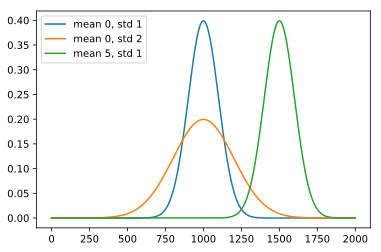

In [30]:
x = np.arange(-10, 10, 0.01)

# 均值和方差组合
params = [(0, 1), (0, 2), (5, 1)]

for (mu, std) in params:
    plt.plot(normal(x, mu, std), label=f'mean {mu}, std {std}')

plt.legend()
plt.show()

如上图所示，改变均值会产生沿$x$轴的偏移，增加方差将会分散分布、降低其峰值(变得矮扁一些)。

均方误差损失函数（简称均方损失）可以用于线性回归的一个原因是： 我们假设了观测中包含噪声，其中噪声服从正态分布。 噪声正态分布如下式:
$$y=\mathbf{w}^{\top} \mathbf{x}+b+\epsilon$$
其中，$\epsilon \sim \mathcal{N}\left(0, \sigma^{2}\right)$

因此，我们现在可以写出通过给定的$\mathbf{x}$观测到特定$y$的*似然*（likelihood）：

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

现在，根据极大似然估计法，参数$\mathbf{w}$和$b$的最优值是使整个数据集的**似然**最大的值：

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)}|\mathbf{x}^{(i)}).$$


根据极大似然估计法选择的估计量称为*极大似然估计量*。虽然使许多指数函数的乘积最大化看起来很困难，但是我们可以在不改变目标的前提下，通过最大化似然对数来简化。

**优化通常是说最小化**而不是最大化。

我们可以改为*最小化负对数似然*$-\log P(\mathbf y \mid \mathbf X)$。

由此可以得到：
$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

* 现在只需要假设$\sigma$是某个固定常数就可以**忽略第一项**，因为第一项不依赖于$\mathbf{w}$和$b$。
* 现在第二项除了常数$\frac{1}{\sigma^2}$外，其余部分和前面介绍的均方误差是一样的。
* 幸运的是，上面式子的解并不依赖于$\sigma$。
因此，在**高斯噪声的假设**下，**最小化均方误差等价于对线性模型的极大似然估计**。

**从线性回归 -> 深层神经网络**

尽管神经网络涵盖了更多更为丰富的模型，我们依然可以用描述神经网络的方式来描述线性模型。因此，和Part1最大的不同点在于，在这里会把线性模型看成一个神经网络，即便其为单层的神经网络，仍然具备我们未来所研究的网络的性质，我们使用下图对神经网络进行描述：

![单层神经网络](https://s2.loli.net/2022/01/14/Z3kRBH8yumcQPWo.png)


在上图所示的神经网络中，输入为$x_1, \ldots, x_d$，因此输入层中的*输入数*（或称为*特征维度*，feature dimensionality）为$d$。
网络的输出为$o_1$，因此输出层中的*输出数*是1。


对于线性回归，每个输入都与每个输出（在本例中只有一个输出）相连，我们将这种变换（上图中的输出层）称为*全连接层*（**fully-connected layer**）或称为*稠密层*（dense layer）。

### 2.1.3 线性回归Pytorch实现

与[1.1中所展示代码](../../1%20AI框架使用(Pytorch)/1.3%20自动微分与简单训练实例/autodiff_training.ipynb)类似,熟悉流程的读者可以直接跳过。

In [31]:
import torch
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2

# 生成数据
def synthetic_data(w, b, num_examples):
    """生成带噪音的数据集 y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

features, labels = synthetic_data(true_w, true_b, 1000)

1. 加载数据

In [32]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

# 转成python的iter
next(iter(data_iter))

[tensor([[-0.2191,  0.8509],
         [-0.2316, -1.2336],
         [ 0.0819,  1.2527],
         [-2.0185, -1.8014],
         [-0.8741, -1.5192],
         [-0.5421, -0.2662],
         [-0.2947,  0.4136],
         [-1.1923,  0.3172],
         [-0.6020, -1.8154],
         [-1.3363, -1.1564]]), tensor([[0.8641],
         [7.9348],
         [0.1000],
         [6.2935],
         [7.6253],
         [4.0137],
         [2.2035],
         [0.7309],
         [9.1779],
         [5.4686]])]

2. 定义模型

In [33]:
# 模型定义
from torch import nn

# 单层神经网络
net = nn.Sequential(nn.Linear(2, 1))

3. 初始化参数

In [34]:
# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

4. 定义损失函数和优化器

In [35]:
# 损失函数
loss = nn.MSELoss()

# 优化器
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

5. 开始训练

In [36]:
# 开始训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)  # 自带模型参数，不需要w和b放进去了
        trainer.zero_grad()  # 优化器梯度清零
        l.backward()  # 自动帮你求sum了
        trainer.step()  # 模型更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000299
epoch 2, loss 0.000102
epoch 3, loss 0.000101


6. 观察参数$w$和$b$的误差

In [37]:
w = net[0].weight.data
print('w的估计误差为：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差为：', true_b - b)

w的估计误差为： tensor([3.3379e-05, 1.4925e-03])
b的估计误差为： tensor([-0.0006])
